# Torch.FX

> Notes on PyTorch programs transformation module called `torch.fx`.

It allows for Python to Python transformations of `torch.nn.Module` instances, allowing for the creation of pipelines of transformations that we can compose.

The 3 main components are:
* Symbolic tracing.
* Provides an IR.
* Utilities for code generation.

The transformations are called *Passes*.

An introductory video about Torch Fx.
{{< video https://www.youtube.com/embed/fbtVDqp3lv8 >}}

In [ ]:
import torch
import torch.nn as nn
from torch.fx import symbolic_trace, GraphModule

In [ ]:
class SimpleModule(nn.Module):

    def __init__(self):
        super().__init__()
        self.param = nn.Parameter(torch.rand(3, 4))
        self.linear = nn.Linear(4, 5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.topk(torch.sum(
            self.linear(x + self.linear.weight).relu(),
            dim=-1), 3)

sm = SimpleModule()
sm_traced: GraphModule = symbolic_trace(sm)

In [ ]:
sm_traced.print_readable()

class SimpleModule(torch.nn.Module):
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        # No stacktrace found for following nodes
        linear_weight = self.linear.weight
        add = x + linear_weight;  x = linear_weight = None
        linear = self.linear(add);  add = None
        relu = linear.relu();  linear = None
        sum_1 = torch.sum(relu, dim = -1);  relu = None
        topk = torch.topk(sum_1, 3);  sum_1 = None
        return topk
        


'class SimpleModule(torch.nn.Module):\n    def forward(self, x : torch.Tensor) -> torch.Tensor:\n        # No stacktrace found for following nodes\n        linear_weight = self.linear.weight\n        add = x + linear_weight;  x = linear_weight = None\n        linear = self.linear(add);  add = None\n        relu = linear.relu();  linear = None\n        sum_1 = torch.sum(relu, dim = -1);  relu = None\n        topk = torch.topk(sum_1, 3);  sum_1 = None\n        return topk\n        '

In [ ]:
print(sm_traced.code)




def forward(self, x : torch.Tensor) -> torch.Tensor:
    linear_weight = self.linear.weight
    add = x + linear_weight;  x = linear_weight = None
    linear = self.linear(add);  add = None
    relu = linear.relu();  linear = None
    sum_1 = torch.sum(relu, dim = -1);  relu = None
    topk = torch.topk(sum_1, 3);  sum_1 = None
    return topk
    


In [ ]:
sm_traced.graph.print_tabular()

opcode         name           target                                                args                kwargs
-------------  -------------  ----------------------------------------------------  ------------------  -----------
placeholder    x              x                                                     ()                  {}
get_attr       linear_weight  linear.weight                                         ()                  {}
call_function  add            <built-in function add>                               (x, linear_weight)  {}
call_module    linear         linear                                                (add,)              {}
call_method    relu           relu                                                  (linear,)           {}
call_function  sum_1          <built-in method sum of type object>   (relu,)             {'dim': -1}
call_function  topk           <built-in method topk of type object>  (sum_1, 3)          {}
output         output         output         

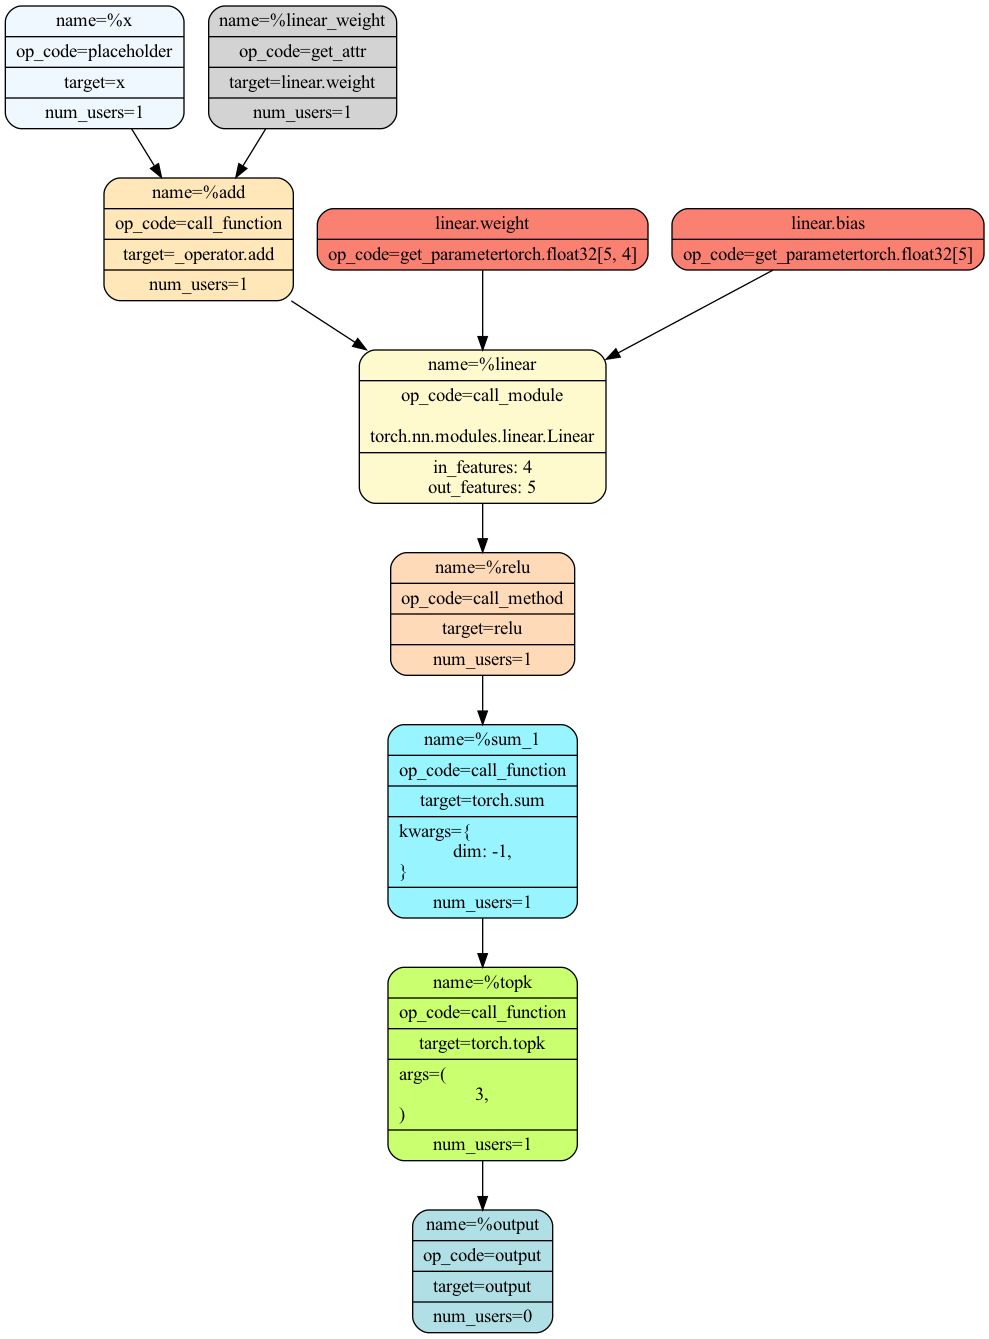

In [ ]:

from torch.fx.passes.graph_drawer import FxGraphDrawer
import IPython

gDrawer = FxGraphDrawer(sm_traced, "SimpleModule")
IPython.display.Image(gDrawer.get_dot_graph().create_png())

### Nodes

The intermediate representation is a `Graph` object, composed of `Nodes`
that represent callsites to various entities.

Properties of a `Node`:

* `graph:Graph`: The `Graph` to which the node belong.
* `name:str`: Name to which the output of this `Node` will be assigned.
* `op:str`: The opcode, possible values: `call_method`, `call_module`, `call_function`, `get_attr`, `output`.
* `target:Union[Callable[..., Any], str]`: The target the op should call.
* `args:Type[Argument]`: Arguments to pass to the `target`.
* `kwargs:dict[str, Argument]`: The kwargs to pass to `target`.
* `return_type:Optional[Any]`: Python type expression repesenting the output of the node.

# GraphModule

It is an `nn.Module` generated from a `fx.Graph`. It contains a `code` and `forward` method that are generated from its `graph` attribute.


# Graph

It is data structure that represents a method on a `GraphModule` and gathers information about: inputs to the method, operations that run inside the method and the output of the method. All of this is represented by `Node` instances.

Method inputs are respresented by *placeholder* `Node`s. The return value is represented by an *output* `Node`. Operations withint the method are represented by *get_attr*, *call_function* and *call_module* `Node`s.


## Modifying Graphs

### Direct manipulation
You can modify the nodes in place and construct new `fx.GraphModule`s.

Note: use `lint` method to make sure the `Graph` is well-formed.

There is as well a lot of utility funcitons that you can use to rewrite `Graph`s.

### Using symbolic tracing
Using the `Proxy` machinery. The idea is to use `Proxy` objects as inputs so that they can automatically record operations into the `Graph`. You can specify rewrite rules as native Python code.

In [ ]:
form torch.fx import Interpreter

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()